In [1]:
import os
import random
import time
from dataclasses import dataclass
import torch
import numpy as np
import tyro
import wandb
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from environment import SimulationSettings, create_env,  create_memory_efficient_env
from ppo import PPO, RolloutBuffer
from typing import List

Device set to : cpu


In [2]:
@dataclass
class Args:
    exp_name: str = "combustion_ppo_1d"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = False
    track: bool = False
    wandb_project_name: str = "combustion_control_1d"
    wandb_entity: str = None
    
    # Environment Parameters
    output_dir: str = 'run/rl_train'
    t_end: float = 0.08
    n_points: int = 100
    global_timestep: float = 1e-5
    
    # Algorithm specific arguments
    total_timesteps: int = 100000
    learning_rate: float = 2.5e-3
    num_envs: int = 1
    num_steps: int = 80
    gamma: float = 0.99
    gae_lambda: float = 0.95
    num_minibatches: int = 16
    update_epochs: int = 10
    eps_clip: float = 0.2
    entropy_coef: float = 0.01
    value_loss_coef: float = 0.5
    max_grad_norm: float = 0.5
    
    save_step_data: bool = False
    
    # Features configuration
    features_config: dict = None
    reward_config: dict = None

def make_env(args):
    """Create environment with specified settings"""
    sim_settings = SimulationSettings(
        output_dir=args.output_dir,
        t_end=args.t_end,
        n_points=args.n_points,
        global_timestep=args.global_timestep
    )
    
    env = create_env(
        sim_settings=sim_settings,
        benchmark_file="env_benchmark.h5",
        species_to_track=['CH4', 'O2', 'CO2', 'H2O'],
        features_config=args.features_config,
        reward_config=args.reward_config,
        save_step_data=args.save_step_data
    )
    return env


def set_integrator_heuristic(solver, fixed_integrator: str = None) -> List[str]:
    """Set integrator type based on temperature and equivalence ratio"""
    nPoints = len(solver.T)
    
    if fixed_integrator is not None:
        return [fixed_integrator] * nPoints
    
    # Start with temperature-based decision
    integ = np.where(solver.T <= 600.0, 'boostRK', 'cvode')
        
    try:
        # Get equivalence ratio
        phi = solver.phi
        
        # Use boostRK for extreme conditions
        integ = np.where(phi == -1, 'boostRK', integ)  # invalid phi
        integ = np.where(phi <= 1e-8, 'boostRK', integ)  # oxidizer-dominated
        integ = np.where(phi >= 1e4, 'boostRK', integ)   # fuel-dominated
        
        # Create boolean mask for CVODE points
        cvode_mask = (integ == 'cvode')
        
        # Include neighboring points
        cvode_mask_left = np.roll(cvode_mask, 1)
        cvode_mask_right = np.roll(cvode_mask, -1)
        cvode_mask_left[0] = False
        cvode_mask_right[-1] = False
        
        use_cvode = cvode_mask | cvode_mask_left | cvode_mask_right
        integ = np.where(use_cvode, 'cvode', 'boostRK')
    except Exception as e:
        print(f"Warning: Could not calculate phi for integrator selection: {e}")
    
    return integ.tolist()

def integrator_to_action(integrators: List[str]) -> List[int]:
    """Convert integrator to action"""
    return [int(integrator == 'boostRK') for integrator in integrators]


In [26]:
# Environment setup
reward_config = {
            'weights': {
                'accuracy': 0.8,
                'efficiency': 0.2,
                'stability': 0
            },
            'thresholds': {
                'time': 0.01,
                'error': 100,
                'stability': 100
            },
            'scaling': {
                'time': 0.1,
                'error': 1.0,
                'stability': 1.0
            }
            }
args = Args(reward_config=reward_config)
env = make_env(args)

# PPO agent setup
state_dim = env.observation_space.shape[1]
action_dim = len(env.integrator_options)

ppo_agent = PPO(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_actor=args.learning_rate,
    lr_critic=args.learning_rate,
    gamma=args.gamma,
    K_epochs=args.update_epochs,
    eps_clip=args.eps_clip,
    has_continuous_action_space=False
)

# Initialize environment
obs, _ = env.reset(seed=args.seed)

jm = 49
Writing output file: run/rl_train/prof000000.h5


/Users/elotech/.local/share/mamba/envs/ember-build1/lib/python3.12/site-packages/ember/input.py:1282: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 0.8 * (x[-1] - x[0]) / (IC.centerWidth + 2 * IC.slopeWidth)


In [4]:
integrator_actions = integrator_to_action(set_integrator_heuristic(env.solver, fixed_integrator='cvode'))

In [27]:
def run_episode(integrator = None):
    obs, _ = env.reset()
    done = False
    episode_length = 0
    episode_actions = []
    global_step = 0
    episode_rewards = []
    episode_errors = []
    episode_lengths = []
    episode_cpu_times = []
    use_rl = False
    while not done:
        # # Get actions for all points
        # if use_rl:
        #     actions = []
        #     for point_obs in obs:
        #         action = ppo_agent.select_action(point_obs, deterministic=True, store_in_buffer=False)
        #         actions.append(action)
        #     actions = np.array(actions)
        # else:
        integrator_actions = integrator_to_action(set_integrator_heuristic(env.solver, fixed_integrator=integrator))
        actions = integrator_actions
        episode_actions.append(actions)
        
        if global_step % 100 == 0:
            print(actions)
            print(f"[EvalSTEP {global_step}] Action Distribution: {np.bincount(actions) / len(actions)}")
        
        obs, rewards, terminated, truncated, info = env.step(actions)
        done = terminated or truncated
        
        episode_rewards.append(rewards)
        episode_errors.append(info['point_errors'])
        episode_cpu_times.append(info['cpu_time'])
        episode_length += 1
        global_step += 1

    return episode_rewards, episode_errors, episode_cpu_times, episode_lengths
    

jm = 49
Writing output file: run/rl_train/prof000000.h5
[EvalSTEP 0] Action Distribution: [0. 1.]


/Users/elotech/.local/share/mamba/envs/ember-build1/lib/python3.12/site-packages/ember/input.py:1282: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 0.8 * (x[-1] - x[0]) / (IC.centerWidth + 2 * IC.slopeWidth)


[EvalSTEP 100] Action Distribution: [0. 1.]
[EvalSTEP 200] Action Distribution: [0. 1.]
[EvalSTEP 300] Action Distribution: [0. 1.]
[EvalSTEP 400] Action Distribution: [0. 1.]
[EvalSTEP 500] Action Distribution: [0. 1.]
[EvalSTEP 600] Action Distribution: [0. 1.]
[EvalSTEP 700] Action Distribution: [0. 1.]
[EvalSTEP 800] Action Distribution: [0. 1.]
[EvalSTEP 900] Action Distribution: [0. 1.]
[EvalSTEP 1000] Action Distribution: [0. 1.]
[EvalSTEP 1100] Action Distribution: [0. 1.]
[EvalSTEP 1200] Action Distribution: [0. 1.]
[EvalSTEP 1300] Action Distribution: [0. 1.]
[EvalSTEP 1400] Action Distribution: [0. 1.]
[EvalSTEP 1500] Action Distribution: [0. 1.]
[EvalSTEP 1600] Action Distribution: [0. 1.]
[EvalSTEP 1700] Action Distribution: [0. 1.]
[EvalSTEP 1800] Action Distribution: [0. 1.]
[EvalSTEP 1900] Action Distribution: [0. 1.]
[EvalSTEP 2000] Action Distribution: [0. 1.]
[EvalSTEP 2100] Action Distribution: [0. 1.]
[EvalSTEP 2200] Action Distribution: [0. 1.]
[EvalSTEP 2300] Act

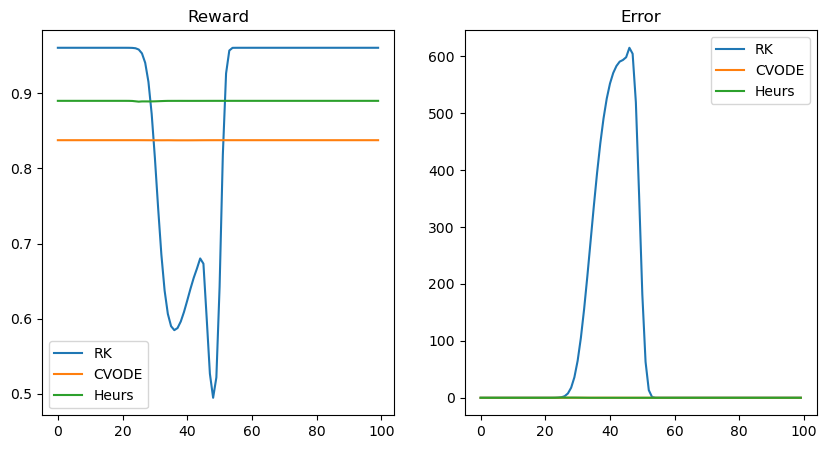

In [34]:
integrators = ['boostRK', 'cvode', 'Heurs']
for integrator in integrators:
    if integrator == 'Heurs':
        integrator = None
    episode_rewards, episode_errors, episode_cpu_times, episode_lengths = run_episode(integrator)
    if integrator == 'boostRK':
        rk_rewards = episode_rewards
        rk_errors = episode_errors
        rk_lengths = episode_lengths
        rk_cpu_times = episode_cpu_times
    elif integrator == 'CVODE':
        cvode_rewards = episode_rewards
        cvode_errors = episode_errors
        cvode_lengths = episode_lengths
        cvode_cpu_times = episode_cpu_times
    else:
        heurs_rewards = episode_rewards
        heurs_errors = episode_errors
        heurs_lengths = episode_lengths
        heurs_cpu_times = episode_cpu_times
        
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[1000], label='RK')
ax[0].plot(cvode_rewards[1000], label='CVODE')
ax[0].plot(heurs_rewards[1000], label='Heurs')
ax[1].plot(rk_errors[1000], label='RK')
ax[1].plot(cvode_errors[1000], label='CVODE')
ax[1].plot(heurs_errors[1000], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()

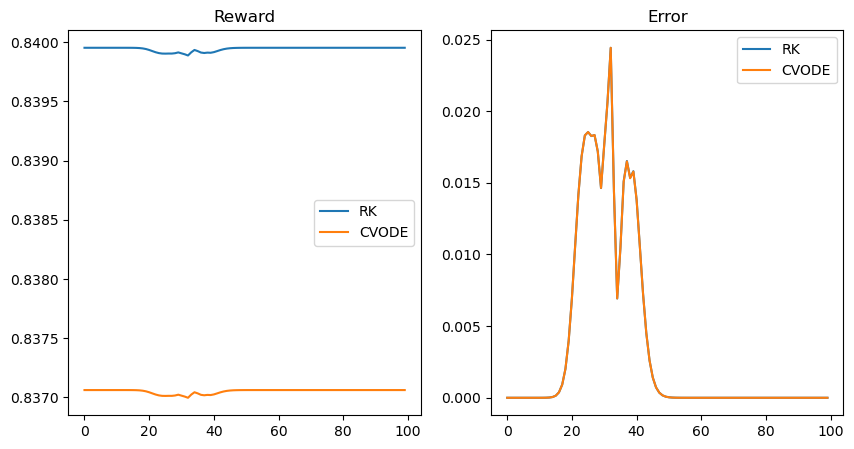

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[-1], label='RK')
ax[0].plot(cvode_rewards[-1], label='CVODE')
# ax[0].plot(heurs_rewards[-1], label='Heurs')
ax[1].plot(rk_errors[-1], label='RK')
ax[1].plot(cvode_errors[-1], label='CVODE')
# ax[1].plot(heurs_errors[-1000], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()

In [16]:
print(f"RK: Min: {rk_cpu_times.min()}, Max: {rk_cpu_times.max()}, Mean: {rk_cpu_times.mean()}, Std: {rk_cpu_times.std()}")
print(f"Heurs: Min: {heurs_cpu_times.min()}, Max: {heurs_cpu_times.max()}, Mean: {heurs_cpu_times.mean()}, Std: {heurs_cpu_times.std()}")
print(f"CVODE: Min: {cvode_cpu_times.min()}, Max: {cvode_cpu_times.max()}, Mean: {cvode_cpu_times.mean()}, Std: {cvode_cpu_times.std()}")


RK: Min: 0.001695871353149414, Max: 0.03055119514465332, Mean: 0.002358449343056284, Std: 0.001653163651846523
Heurs: Min: 0.00432896614074707, Max: 0.06148815155029297, Mean: 0.009068244127787242, Std: 0.0026140245908824267
CVODE: Min: 0.014897823333740234, Max: 0.06359386444091797, Mean: 0.016437758353687163, Std: 0.002407767669820944


In [14]:
rk_errors = np.array(rk_errors)
heurs_errors = np.array(heurs_errors)
cvode_errors = np.array(cvode_errors)

print(f"RK: Min: {rk_errors.min()}, Max: {rk_errors.max()}, Mean: {rk_errors.mean()}, Std: {rk_errors.std()}")
print(f"Heurs: Min: {heurs_errors.min()}, Max: {heurs_errors.max()}, Mean: {heurs_errors.mean()}, Std: {heurs_errors.std()}")
print(f"CVODE: Min: {cvode_errors.min()}, Max: {cvode_errors.max()}, Mean: {cvode_errors.mean()}, Std: {cvode_errors.std()}")


RK: Min: 0.0, Max: 2332.96122119736, Mean: 195.61464013288054, Std: 418.0620060017075
Heurs: Min: 0.0, Max: 482.0468172473458, Mean: 0.23164077517617676, Std: 1.8416115755288693
CVODE: Min: 0.0, Max: 546.4130135843553, Mean: 0.08522859851901499, Std: 2.2090658606440416


In [45]:
print(heurs_cpu_times.min())
print(heurs_cpu_times.max())
print(heurs_cpu_times.mean())
print(heurs_cpu_times.std())

print("--------------------------------")

print(cvode_cpu_times.min())
print(cvode_cpu_times.max())
print(cvode_cpu_times.mean())
print(cvode_cpu_times.std())


0.004436016082763672
0.05449509620666504
0.009025832598553387
0.0024702447978440403
--------------------------------
0.014853954315185547
0.09123587608337402
0.01673633445945791
0.002979845118673032


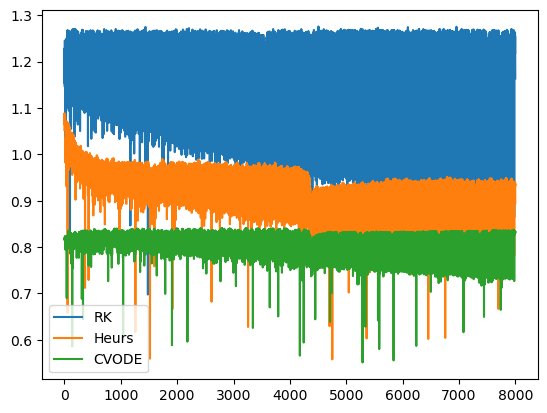

In [15]:
rk_cpu_times = np.array(rk_cpu_times)
heurs_cpu_times = np.array(heurs_cpu_times)
cvode_cpu_times = np.array(cvode_cpu_times)

plt.plot(-np.log(rk_cpu_times)/5, label='RK')
plt.plot(-np.log(heurs_cpu_times)/5, label='Heurs')
plt.plot(-np.log(cvode_cpu_times)/5, label='CVODE')
plt.legend()
plt.show()

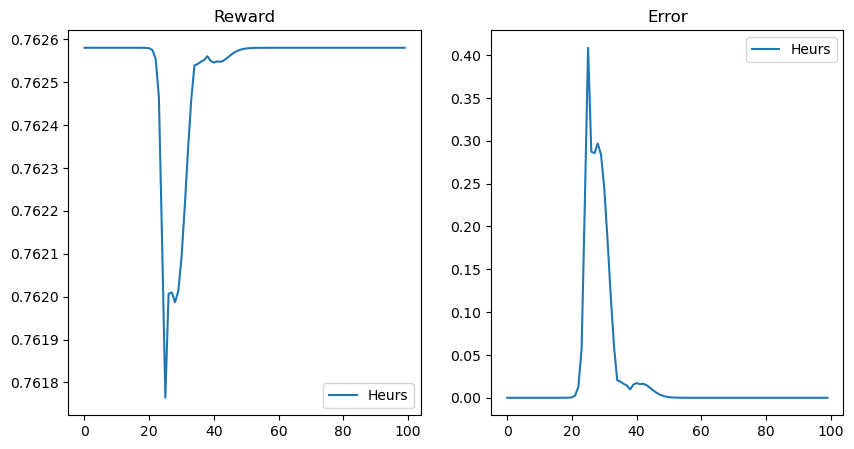

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[1000], label='RK')
ax[0].plot(cvode_rewards[1000], label='CVODE')
ax[0].plot(heurs_rewards[1000], label='Heurs')
ax[1].plot(rk_errors[1000], label='RK')
ax[1].plot(cvode_errors[1000], label='CVODE')
ax[1].plot(heurs_errors[1000], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()


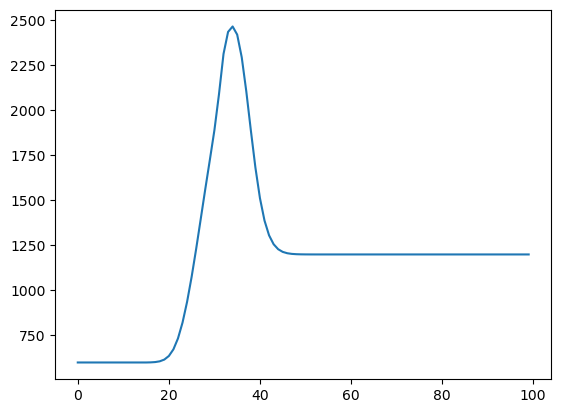

In [18]:
plt.plot(env.solver.T)
plt.show()

In [86]:
cpu_time = info['cpu_time']

In [93]:
cpu_time


0.002125978469848633

In [96]:
-np.log10(cpu_time)/10

np.float64(0.2672441137965723)

In [87]:
weights['efficiency'] * np.exp(-scaling['time'] * cpu_time / thresholds['time'])

np.float64(0.29368938345178325)

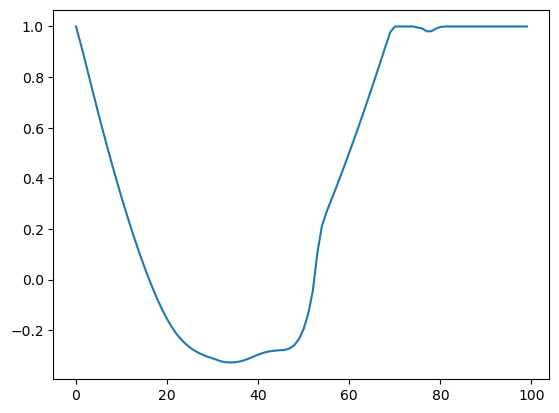

In [73]:
T_es = np.array(T_errors)

logTes = -np.log10(np.maximum(T_es, 1e-10))/10
plt.plot(logTes)
plt.show()

In [81]:
species_errors.keys()

dict_keys(['CH4', 'O2', 'CO2', 'H2O'])

In [82]:
err = species_errors['CH4']

In [85]:
err

np.float64(0.0)

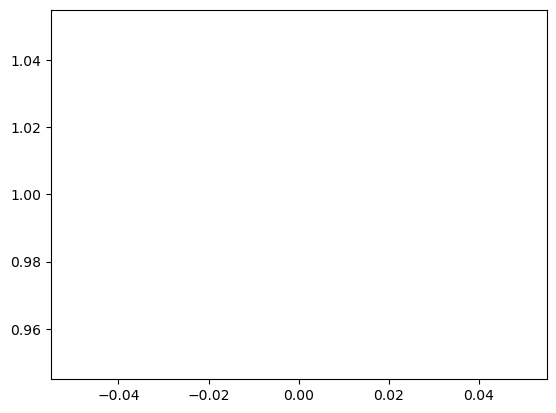

In [84]:
logEs = -np.log10(np.maximum(err, 1e-10))/10
plt.plot(logEs)
plt.show()

In [53]:
weights = env.reward_config['weights']
thresholds = env.reward_config['thresholds']
scaling = env.reward_config['scaling']

# Accuracy reward
temp_reward = np.exp(-scaling['error'] * np.array(T_errors) / thresholds['error'])

In [66]:
species_errors

{'CH4': np.float64(0.0),
 'O2': np.float64(5.551115123125783e-17),
 'CO2': np.float64(0.0),
 'H2O': np.float64(0.0)}

In [ ]:
species_reward = np.mean([
    np.exp(-scaling['error'] * error / thresholds['error'])
    for error in species_errors.values()
])

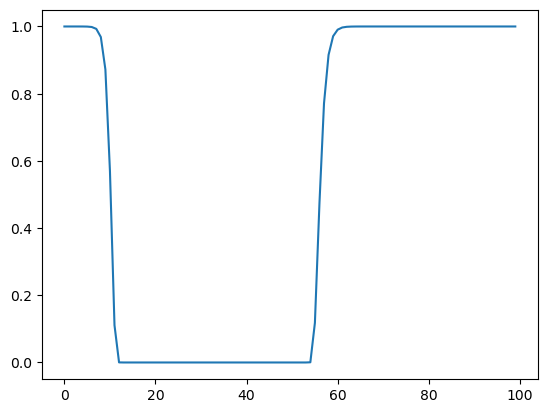

In [55]:
plt.plot(temp_reward)
plt.show()

In [49]:

species_reward = np.mean([
    np.exp(-scaling['error'] * error / thresholds['error'])
    for error in species_errors.values()
])
grad_reward = np.exp(-scaling['error'] * grad_error / thresholds['error'])

accuracy_reward = weights['accuracy'] * (temp_reward + species_reward + grad_reward) / 3

# Efficiency reward
time_reward = weights['efficiency'] * np.exp(-scaling['time'] * info['cpu_time'] / thresholds['time'])

In [50]:
accuracy_reward

np.float64(0.5999999906776768)

In [57]:
import numpy as np

def calculate_reward(cpu_time, error, time_weight=0.4):
    """
    Calculate reward score for an integration method based on CPU time and error.
    Uses dynamic normalization that doesn't require knowing global min/max values.
    
    Parameters:
    -----------
    cpu_time : float
        CPU time taken by the integrator
    error : float
        Error of the integration result
    time_weight : float, optional (default=0.4)
        Weight for the CPU time component (0 to 1)
        Error weight will be (1 - time_weight)
    
    Returns:
    --------
    float
        Reward score (higher is better)
    """
    # Prevent division by zero or negative values
    cpu_time = max(cpu_time, 1e-10)
    error = max(error, 1e-10)
    
    # Transform CPU time using negative exponential
    # This makes smaller times exponentially better
    # and naturally bounds the score between 0 and 1
    time_score = np.exp(-cpu_time / 0.05)  # 0.01 is a scaling factor
    
    # Transform error similarly with appropriate scaling
    # Using a different scale for error since it has a different range
    error_score = np.exp(-error / 100.0)  # 10.0 is a scaling factor
    
    # Combine scores with weights
    final_score = (time_weight * time_score + 
                  (1 - time_weight) * error_score)
    
    return final_score

def test_reward_function():
    # Test data
    test_cases = [
        # (cpu_time, error)
        (0.001687765121459961, 0.1),  # Very fast, good accuracy
        (0.09123587608337402, 0.1),   # Slow, good accuracy
        (0.001687765121459961, 100),  # Very fast, poor accuracy
        (0.09123587608337402, 100),   # Slow, poor accuracy
        (0.01, 1.0),                  # Medium case
    ]
    
    print("Testing reward function with various cases:")
    for time, error in test_cases:
        score = calculate_reward(time, error)
        print(f"Time: {time:.6f}, Error: {error:.6f}, Score: {score:.6f}")
    
    # Test with your example data
    integrators = {
        'RK': {
            'time': {'mean': 0.0023427907154839707},
            'error': {'mean': 195.61464013288054}
        },
        'Heurs': {
            'time': {'mean': 0.009025832598553387},
            'error': {'mean': 0.23173495163231658}
        },
        'CVODE': {
            'time': {'mean': 0.01673633445945791},
            'error': {'mean': 0.08525023770717294}
        }
    }
    
    print("\nReward scores using mean values from your data:")
    for method, data in integrators.items():
        score = calculate_reward(data['time']['mean'], data['error']['mean'])
        print(f"{method}: {score:.6f}")

if __name__ == "__main__":
    test_reward_function()

Testing reward function with various cases:
Time: 0.001688, Error: 0.100000, Score: 0.986124
Time: 0.091236, Error: 0.100000, Score: 0.663906
Time: 0.001688, Error: 100.000000, Score: 0.607451
Time: 0.091236, Error: 100.000000, Score: 0.285233
Time: 0.010000, Error: 1.000000, Score: 0.921522

Reward scores using mean values from your data:
RK: 0.466531
Heurs: 0.932547
CVODE: 0.885702


In [44]:
len(rk_errors)

7998

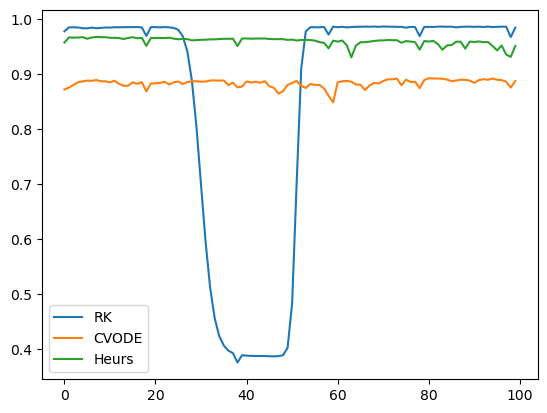

In [59]:
rk_rewardss = []
cvode_rewardss = []
heurs_rewardss = []
for point in range(100):
    rk_reward = calculate_reward(rk_cpu_times[point], rk_errors[1000][point])
    cvode_reward = calculate_reward(cvode_cpu_times[point], cvode_errors[1000][point])
    heurs_reward = calculate_reward(heurs_cpu_times[point], heurs_errors[1000][point])
    rk_rewardss.append(rk_reward)
    cvode_rewardss.append(cvode_reward)
    heurs_rewardss.append(heurs_reward)
plt.plot(rk_rewardss, label='RK')
plt.plot(cvode_rewardss, label='CVODE')
plt.plot(heurs_rewardss, label='Heurs')
plt.legend()
plt.show()